### Influence of all the additional features added on the predictions

In [31]:
import pandas as pd

# Load the dataset
df = pd.read_excel("New Datasets/complete_dataset.xlsx", engine="openpyxl")

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

In [33]:
# Feature engineering
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['is_december'] = (df['month'] == 12).astype(int)
df['time_index'] = (df['date'] - df['date'].min()).dt.days // 30
df['cpi_lag1'] = df['cpi'].shift(1)
df['cpi_lag3'] = df['cpi'].shift(3)
df['cpi_rollmean3'] = df['cpi'].rolling(window=3).mean()
df['cpi_rollstd3'] = df['cpi'].rolling(window=3).std()
df['cpi_yoy_change'] = df['cpi'].pct_change(12) * 100  # Year-over-Year %

df_clean = df.dropna().reset_index(drop=True)
saved_clean_dataset = df_clean.to_csv('New Datasets/macro_indicators + additional_features.csv')

/tmp/ipykernel_479/92700772.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quarter', y='cpi', data=df_clean, ax=axs[2], palette="Set2")


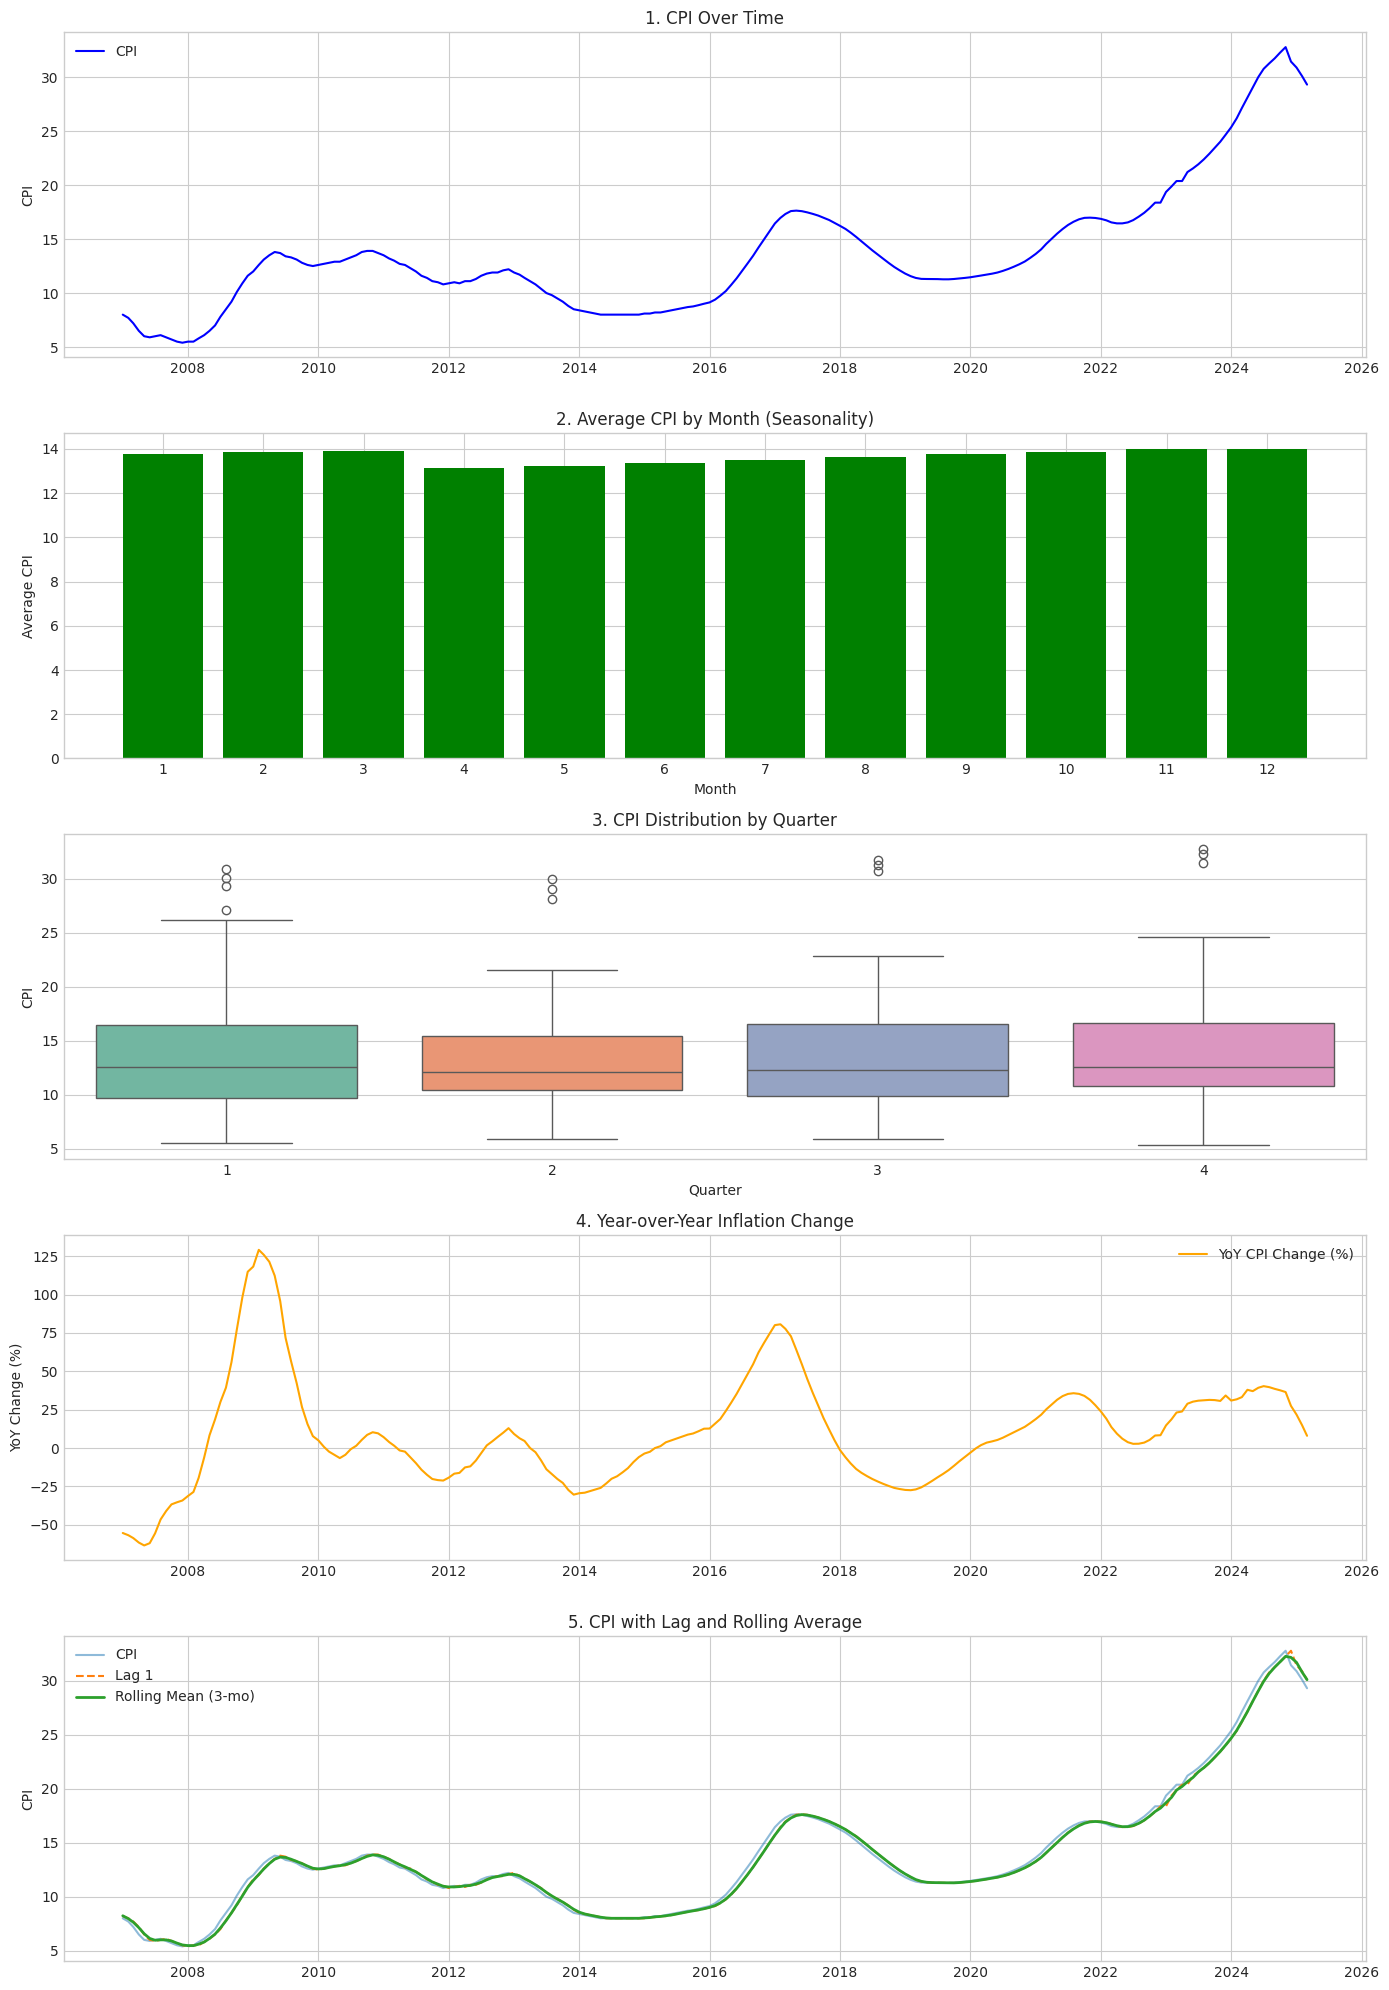

In [34]:
# Set style
plt.style.use("seaborn-v0_8-whitegrid")
fig, axs = plt.subplots(5, 1, figsize=(14, 20))

# 1. CPI over time
axs[0].plot(df_clean['date'], df_clean['cpi'], label='CPI', color='blue')
axs[0].set_title("1. CPI Over Time")
axs[0].set_ylabel("CPI")
axs[0].legend()

# 2. Average CPI by month
monthly_avg = df_clean.groupby('month')['cpi'].mean()
axs[1].bar(monthly_avg.index, monthly_avg.values, color='green')
axs[1].set_title("2. Average CPI by Month (Seasonality)")
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Average CPI")
axs[1].set_xticks(range(1, 13))

# 3. Boxplot by quarter
sns.boxplot(x='quarter', y='cpi', data=df_clean, ax=axs[2], palette="Set2")
axs[2].set_title("3. CPI Distribution by Quarter")
axs[2].set_xlabel("Quarter")
axs[2].set_ylabel("CPI")

# 4. Year-over-Year % change
axs[3].plot(df_clean['date'], df_clean['cpi_yoy_change'], color='orange', label='YoY CPI Change (%)')
axs[3].set_title("4. Year-over-Year Inflation Change")
axs[3].set_ylabel("YoY Change (%)")
axs[3].legend()

# 5. Rolling mean and lag
axs[4].plot(df_clean['date'], df_clean['cpi'], label='CPI', alpha=0.5)
axs[4].plot(df_clean['date'], df_clean['cpi_lag1'], label='Lag 1', linestyle='--')
axs[4].plot(df_clean['date'], df_clean['cpi_rollmean3'], label='Rolling Mean (3-mo)', linewidth=2)
axs[4].set_title("5. CPI with Lag and Rolling Average")
axs[4].set_ylabel("CPI")
axs[4].legend()

plt.tight_layout()
plt.show()


In [38]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Clean main dataset
df_clean = df_clean.dropna().reset_index(drop=True)

# Evaluation function
def evaluate_model(X, y, model_type, label):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    model = LinearRegression() if model_type == "LinearRegression" else RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "Variant": label,
        "Model": model_type,
        "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred)), 3),
        "R²": round(r2_score(y_test, y_pred), 3)
    }

# Prepare variants
results = []

# Variant 1: Monthly Raw
features_v1 = ['exchange_rate(naira_to_usd)', 'interest_rate', 'money_supply']
X1 = df_clean[features_v1]
y1 = df_clean['cpi']
for model in ["LinearRegression", "RandomForest"]:
    results.append(evaluate_model(X1, y1, model, "Monthly Raw"))

# Variant 2: + Seasonality
features_v2 = features_v1 + ['month', 'quarter', 'is_december']
X2 = df_clean[features_v2]
y2 = df_clean['cpi']
for model in ["LinearRegression", "RandomForest"]:
    results.append(evaluate_model(X2, y2, model, "Monthly + Seasonality"))

# Variant 3: + Lag/Rolling
features_v3 = features_v2 + ['cpi_lag1', 'cpi_lag3', 'cpi_rollmean3', 'cpi_rollstd3']
X3 = df_clean[features_v3]
y3 = df_clean['cpi']
for model in ["LinearRegression", "RandomForest"]:
    results.append(evaluate_model(X3, y3, model, "Monthly + Lag/Rolling"))

# Variant 4: Quarterly
df_quarter = df.set_index('date').resample('QE').mean().dropna().reset_index()
df_quarter['quarter'] = df_quarter['date'].dt.quarter
features_q = ['exchange_rate(naira_to_usd)', 'interest_rate', 'money_supply', 'quarter']
X4 = df_quarter[features_q]
y4 = df_quarter['cpi']
for model in ["LinearRegression", "RandomForest"]:
    results.append(evaluate_model(X4, y4, model, "Quarterly"))

# Variant 5: YoY Change
df_yoy = df.dropna(subset=['cpi_yoy_change']).reset_index(drop=True)
X5 = df_yoy[features_v1]
y5 = df_yoy['cpi_yoy_change']
for model in ["LinearRegression", "RandomForest"]:
    results.append(evaluate_model(X5, y5, model, "YoY Change"))

# Display results
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='RMSE'))


                 Variant             Model    RMSE     R²
4  Monthly + Lag/Rolling  LinearRegression   0.192  0.999
6              Quarterly  LinearRegression   8.193 -1.102
5  Monthly + Lag/Rolling      RandomForest   8.318 -1.166
0            Monthly Raw  LinearRegression   8.724 -1.382
2  Monthly + Seasonality  LinearRegression   8.780 -1.413
1            Monthly Raw      RandomForest   8.826 -1.438
3  Monthly + Seasonality      RandomForest   8.974 -1.521
7              Quarterly      RandomForest   9.142 -1.618
9             YoY Change      RandomForest  13.595 -0.270
8             YoY Change  LinearRegression  26.741 -3.916


### Using Monthly + Lag

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

features_v3 = features_v2 + ['cpi_lag1', 'cpi_lag3', 'cpi_rollmean3', 'cpi_rollstd3']
X3 = df_clean[features_v3]
y3 = df_clean['cpi']


# 4. Train-test split using time-series split
split = int(len(df) * 0.8)
X_train, X_test = X3.iloc[:split], X3.iloc[split:]
y_train, y_test = y3.iloc[:split], y3.iloc[split:]

# 5. Train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Make predictions
y_pred = model.predict(X_test)

# 7. Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


RMSE: 0.217
R²: 0.998


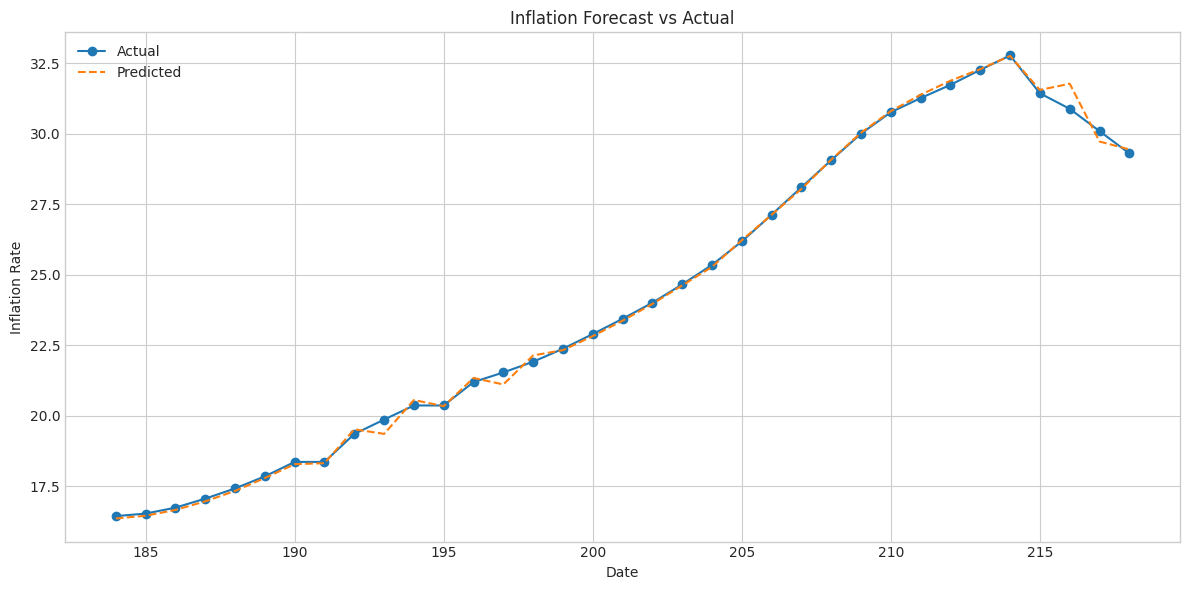

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual", marker='o')
plt.plot(y_test.index, y_pred, label="Predicted", linestyle='--')
plt.title("Inflation Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
